<a href="https://colab.research.google.com/github/estebanegm/PINN_example/blob/main/PINN_example_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se resuelve la siguiente ecuación diferencial:
\begin{align}
\frac{d^{2} u}{dt^{2}} +w^2u = 0
\end{align}

*   Condicion iniciales:
\begin{align}
u(0) = 1\\
\\
u'(0) = 0
\end{align}


*   Se hace una red neuronal y función de pérdida como la siguiente:
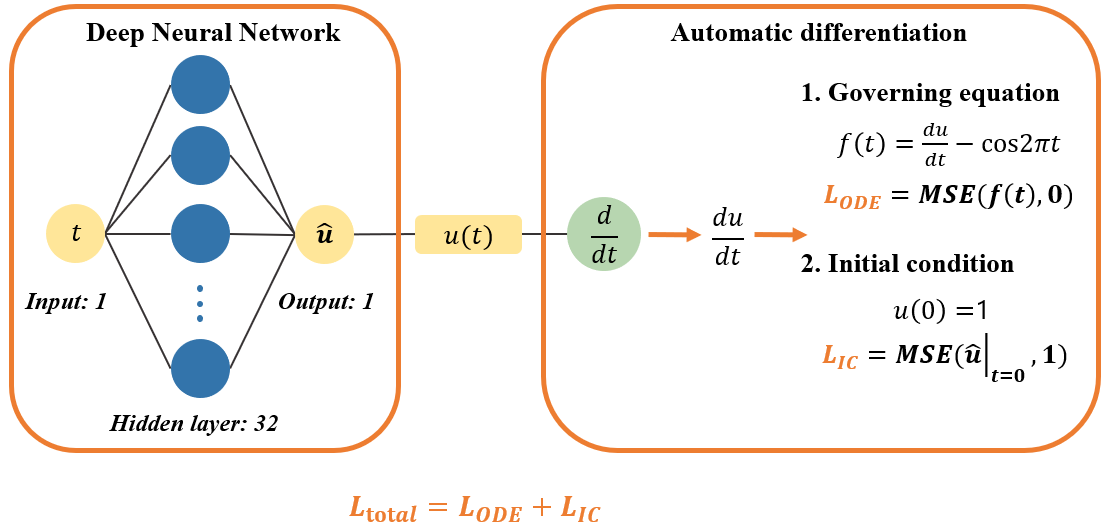


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Definir la red neuronal
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(units=50, activation='tanh'),
    tf.keras.layers.Dense(units=1)
])

In [3]:
NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                100       
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 151 (604.00 Byte)
Trainable params: 151 (604.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
optm = tf.keras.optimizers.Adam(learning_rate=0.001)

Se define el sistema de ecuaciones diferenciales ordinarias (ODE System)


*   ODE LOSS:

\begin{align}
L_{\text{ODE}} = \frac{1}{n}\sum_{i=1}^{n} \left(\frac{d^{2} \text{NN}(t_i)}{dt^{2}}- \omega x_i\right)^2
\end{align}

*   Initial Condition LOSS:
\begin{align}
  L_{IC_1} = \frac{1}{n}\sum_{i=1}^{n} \left({\text{NN}(0)}- 1\right)^2
\end{align}

\begin{align}
  L_{IC_2} = \frac{1}{n}\sum_{i=1}^{n} \left(\frac{d \text{NN}(0)}{dt}- 0\right)^2
\end{align}

\begin{align}
  L_{IC} = L_{IC_1}+L_{IC_2}
\end{align}

*   Total LOSS:
\begin{align}
L_{\text{Total}} = L_{\text{ODE}} + L_{\text{IC}}
\end{align}

In [5]:
def ode_system(t, net, omega):
    t = t.reshape(-1,1)
    t = tf.constant(t, dtype = tf.float32)
    t_0 = tf.zeros((1,1))
    one = tf.ones((1,1))

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)

        x = net(t)  # La red neuronal representa la posición x en función de t
        x_first_deriv = tape.gradient(x, t)

    x_second_deriv = tape.gradient(x_first_deriv, t)
    # del tape

    ode_loss = x_second_deriv + (omega**2) * x

    # Condiciones iniciales
    position_loss = net(t_0) - one # Posicion inicial=1
    velocity_loss = x_first_deriv(t_0) - t_0 # Velocidad Inicial = 0

    square_loss = tf.square(ode_loss) + tf.square(position_loss) + tf.square(velocity_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

In [6]:
# Parámetros del oscilador armónico simple
omega = 2.0

# Datos de entrenamiento
# train_t = np.linspace(0, 10, 100).reshape(-1, 1)
train_t = (np.random.rand(10000)*10).reshape(-1, 1)
train_loss_record = []

for itr in range(8000):
    with tf.GradientTape() as tape:
        train_loss = ode_system(train_t, NN, omega)
        train_loss_record.append(train_loss)

        grad_w = tape.gradient(train_loss, NN.trainable_variables)
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))

    if itr % 1000 == 0:
        print(train_loss.numpy())


24.151735
0.94091463
0.9402588
0.93993986
0.93946564
0.9387695
0.937982
0.93706447


In [7]:
print(train_t)

[[6.272808  ]
 [7.14250634]
 [1.36103312]
 ...
 [3.34554864]
 [8.55795001]
 [7.1883186 ]]


In [8]:
net(t_0)

NameError: ignored

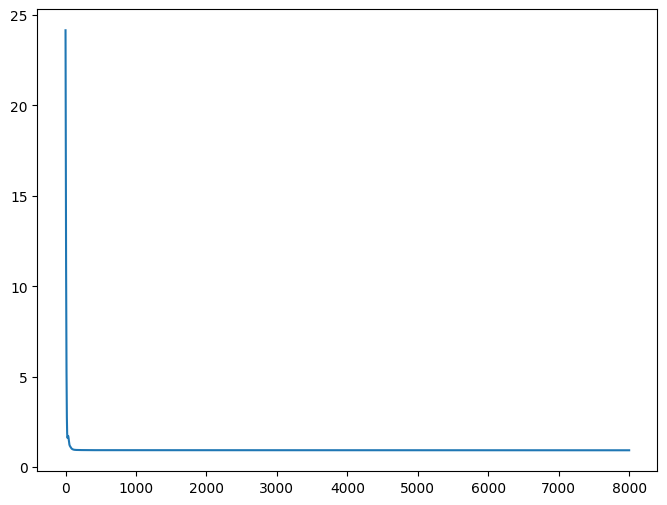

In [9]:
# Gráfica de la pérdida durante el entrenamiento
plt.figure(figsize=(8, 6))
plt.plot(train_loss_record)
plt.show()


4/4 [==============================] - 0s 2ms/step


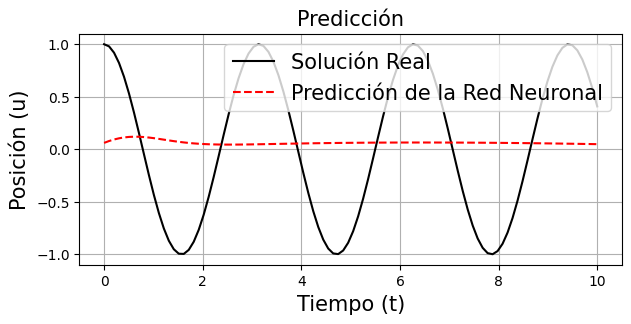

In [10]:
# Valores de prueba
test_t = np.linspace(0, 10, 100)

omega = 2.0  # Frecuencia angular del oscilador
A = 1.0  # Amplitud del oscilador
phi = 0.0  # Fase inicial del oscilador

# Solución real del oscilador armónico simple
true_u = A * np.cos(omega * test_t + phi)

#Predicción
pred_u = NN.predict(test_t).ravel()

# Gráfica de la solución real y la predicción
plt.figure(figsize=(7, 3))
plt.plot(test_t, true_u, '-k', label='Solución Real')
# Gráfica de la predicción
# plt.figure(figsize=(7, 3))
plt.plot(test_t, pred_u, '--r', label='Predicción de la Red Neuronal')
plt.legend(fontsize=15, loc='upper right')
plt.xlabel('Tiempo (t)', fontsize=15)
plt.ylabel('Posición (u)', fontsize=15)
plt.title('Predicción', fontsize=15)
plt.grid(True)
plt.show()